In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm

In [3]:
mnist_train = datasets.MNIST(
    'data',
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor()]
    )
)
mnist_test = datasets.MNIST(
    'data',
    train=False,
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor()]
    )
)
X_train = mnist_train.data / 255.
Y_train = mnist_train.targets

X_test = mnist_test.data / 255.
Y_test = mnist_test.targets

In [6]:
class AliceNet(nn.Module):
    def __init__(self):
        super(AliceNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, (5, 5))
        self.conv2 = nn.Conv2d(6, 16, (5, 5))
        
        self.fc1 = nn.Linear(16 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

    def convs(self, x):
        x = [x]
        x.append(F.max_pool2d(F.relu(self.conv1(x[-1])), (2, 2)))
        x.append(F.max_pool2d(F.relu(self.conv2(x[-1])), (2, 2)))
        return x[1:]

net = AliceNet()
print(net)

AliceNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [7]:
BATCH_SIZE = 128

train_loader = torch.utils.data.DataLoader(
    mnist_train,
    batch_size = BATCH_SIZE,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    mnist_test,
    batch_size = BATCH_SIZE,
    shuffle=False
)


def train(model, train_loader, optimizer, epochs):
    batches = len(train_loader)
    loss_fn = nn.NLLLoss()
    
    losses, acc = [], []
    for epoch in range(epochs):
        batch_iterator = tqdm(train_loader, total=batches, unit=' batch(s)')
        for batch_idx, (x, target) in enumerate(batch_iterator):
            optimizer.zero_grad()
            out = model(x)
            loss = loss_fn(out, target)
            loss.backward()
            losses.append(loss.item())
            acc.append(
                (torch.count_nonzero(target == torch.tensor([torch.argmax(i) for i in out]))/len(target)).item()
            )
            optimizer.step()
            batch_iterator.set_description(f"Epoch {epoch + 1}/{epochs}")
            batch_iterator.set_postfix({
                'loss': loss.item(),
                'acc': acc[-1]
            })

    
    return losses, acc

        
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
losses, acc = train(net, train_loader, optimizer, epochs=3)

  0%|          | 0/469 [00:00<?, ? batch(s)/s]

  0%|          | 0/469 [00:00<?, ? batch(s)/s]

  0%|          | 0/469 [00:00<?, ? batch(s)/s]

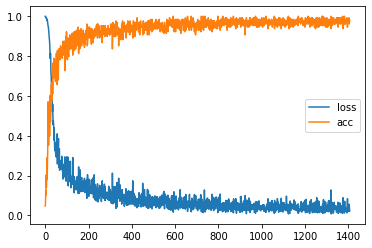

In [8]:
batch_iter = torch.arange(len(losses))
plt.plot(batch_iter, torch.tensor(losses)/max(losses))
plt.plot(batch_iter, acc)
plt.legend(['loss', 'acc'])

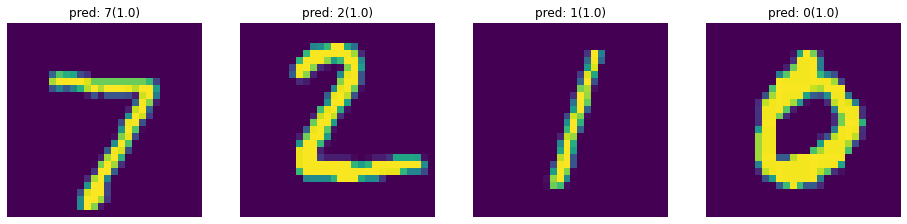

In [9]:
labels = torch.arange(0, 10).detach().numpy()

fig = plt.figure(figsize=(16, 8))
for i, im in enumerate(X_test[0:4]):
    ax = fig.add_subplot(2, 4, i+1)
    ax.axis('off')
    plt.imshow(im)
    out = net(im.reshape(1, 1, 28, 28))
    pred = torch.argmax(out)
    conf = round(((torch.abs(out[0][pred]**-1))/(torch.abs(out)**-1).sum()).item(), 2)
    plt.title(f'pred: {torch.argmax(out)}({(conf)})')

## Visualizing output from conv layers 1 and 2 after maxpool

First Convolutional layer(6 channels out)


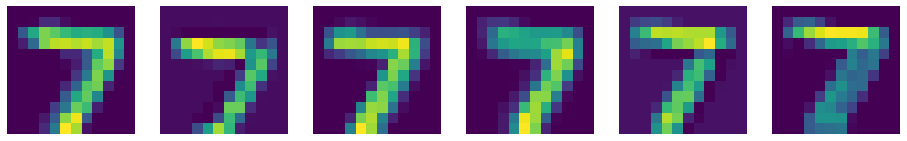

In [10]:
fig = plt.figure(figsize=(16, 8))
print(f'First Convolutional layer({net.conv1.out_channels} channels out)')

for i, im in enumerate(net.convs(X_test[0].reshape(1,1,28,28))[0][0]):
    ax = fig.add_subplot(1, net.conv1.out_channels, i+1)
    ax.axis('off')
    plt.imshow(im.detach().numpy())

Second Convolutional layer(16 channels out)


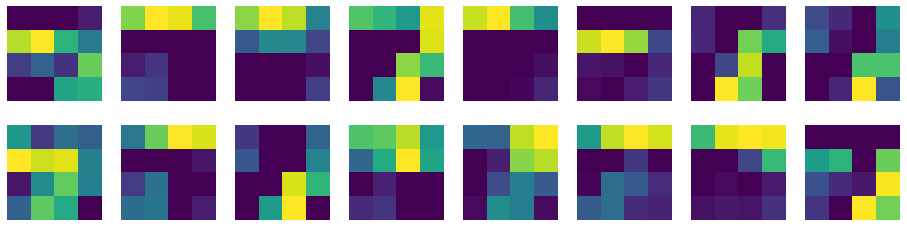

In [11]:
print(f'Second Convolutional layer(16 channels out)')
fig = plt.figure(figsize=(16, 4))

for i, im in enumerate(net.convs(X_test[0].reshape(1,1,28,28))[1][0]):
    ax = fig.add_subplot(2, 8, i+1)
    ax.axis('off')
    plt.imshow(im.detach().numpy())

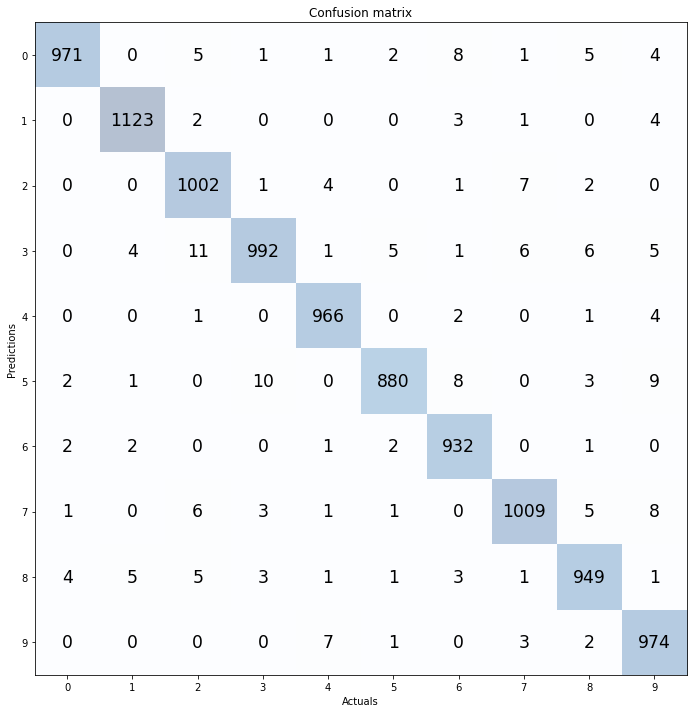

In [12]:
def plot_confusion_matrix(y_pred, y_actual):
    conf_matrix = confusion_matrix(y_pred, y_actual)
    fig, ax = plt.subplots(figsize=(12, 12))
    plt.title('Confusion matrix')
    plt.imshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    plt.xlabel('Actuals')
    plt.ylabel('Predictions')
    ax.set_xticks(list(range(10)))
    ax.set_yticks(list(range(10)))
    
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

preds = torch.tensor([torch.argmax(pred) for pred in net(X_test.reshape(10000, 1, 28, 28))], requires_grad=False)
plot_confusion_matrix(preds, Y_test)